# Removing Glasses from an image through recursive PCA

## Setup Data

### Import Necessary Libraries

In [611]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.io as sio

### Load Data

In [612]:
# Load Imgaes Images as Dataset
def load_pgm_images(amount_of_people, amount_of_pics):
    images = []
    for person in range(1, amount_of_people+1):
        images.append([])
        for image_number in range(1, amount_of_pics+1):
            img = Image.open('images/s' + str(person) + '/' + str(image_number) + '.pgm')
            images[person-1].append(img)
    return np.array(images)
    
def display_pgm_images(images, person_numbers, pic_numbers):
    rows, cols = len(person_numbers), len(pic_numbers)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    row = 0
    for i in person_numbers:
        col = 0
        for j in pic_numbers:
            ax = axes[row, col]
            ax.imshow(images[i][j], cmap='gray')
            ax.axis('off')
            col += 1
        row += 1
            
    plt.tight_layout()
    plt.show()
    

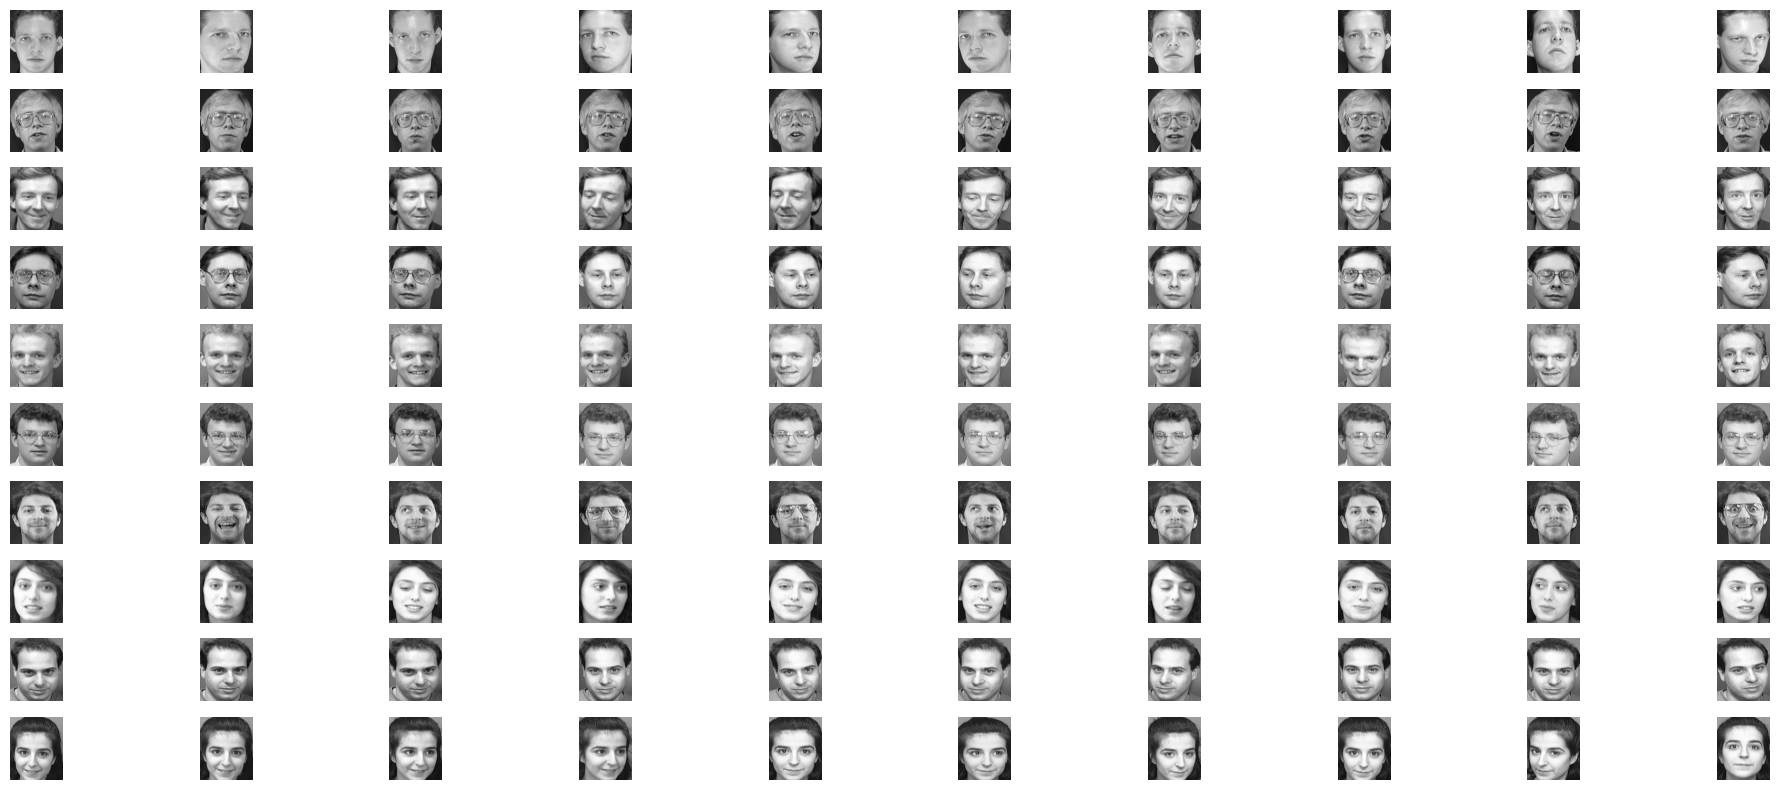

In [613]:
# Example of images
amount_of_people = 40
amount_of_pics = 10
# person_numbers = [0, 1, 5, 14, 25, 29, 30, 32]
person_numbers = range(0, 10)
pic_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
images = load_pgm_images(40, 10)
display_pgm_images(images, person_numbers, pic_numbers)

Note: The images folder contains 40 folders, each with 10 images (each folder is of a different person, and each of the 10 images contains different features of the person). Each image is 112x92 pixels

### Process Data

(10304, 72)


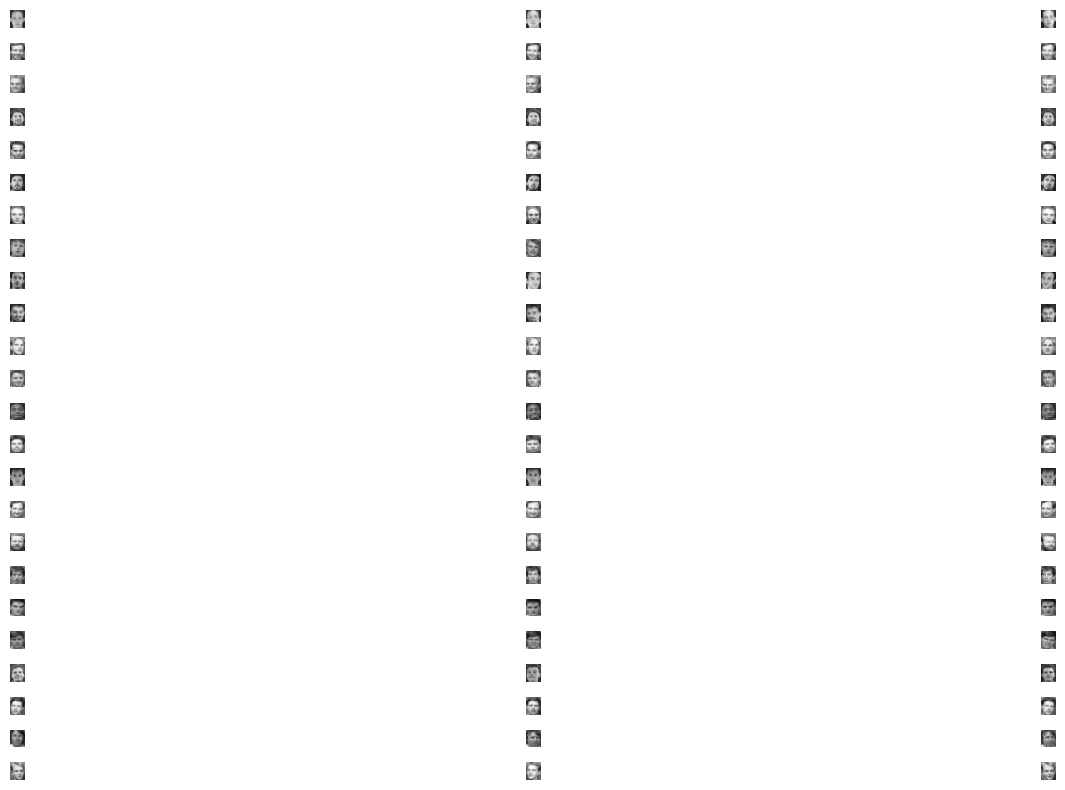

In [628]:
# Create Dataset of Male and Without Glasses
selected_people = [0, 2, 4, 6, 8, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 28, 29, 32, 35, 37, 38, 39]
male_no_glasses_imgs = np.array([images[i] for i in selected_people])
selected_imgs = [0, 6, 7]

# Create Dataset for male with no glasses to perform PCA with
num_people = len(selected_people)
num_pictures = len(selected_imgs)
num_pixels = 112 * 92
num_images = num_people * num_pictures
ds = np.zeros((num_people, num_pictures, num_pixels))

# Function flattens matrix to n x 1 column
def flatten_matrix(matrix):
    return matrix.reshape(1, -1)

# flatten pixels
for i in range(num_people):
    for j in range(num_pictures):
        ds[i][j] = flatten_matrix(male_no_glasses_imgs[i][j])

# Flatten pictures
ds = ds.reshape(num_people * num_pictures, num_pixels)
ds = ds.T
print(ds.shape)
# Normalize columns

# Display selected pictures
display_pgm_images(images, selected_people, selected_imgs)

## Perform PCA on Glassless Dataset (50 components first)

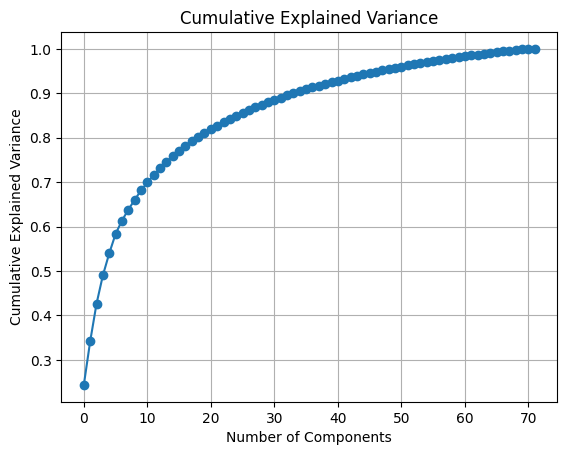

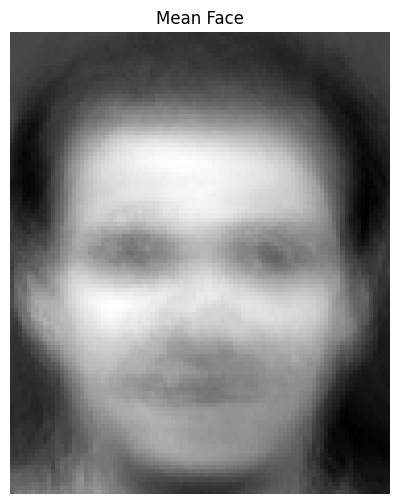

In [629]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

mean_face = np.mean(ds, axis=1, keepdims=True)
Z = ds - mean_face
pca = PCA()
principal_components = pca.fit_transform(Z.T)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape((112, 92)), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mean_face.reshape((112, 92)), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

#print("Principal Components Shape:", principal_components.shape)
#print("Explained Variance Ratio:", explained_variance_ratio)
#print("Cumulative Explained Variance:", cumulative_variance)

# One Fourth Principal Components

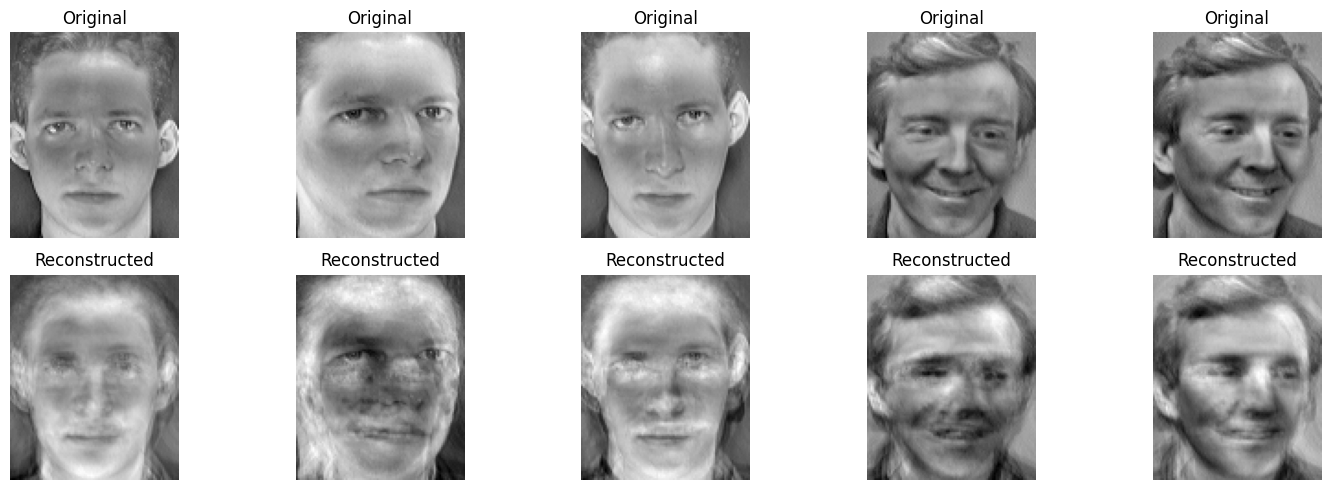

In [630]:
pca = PCA(n_components=int(num_images/4))
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)

# One Half Principal Components

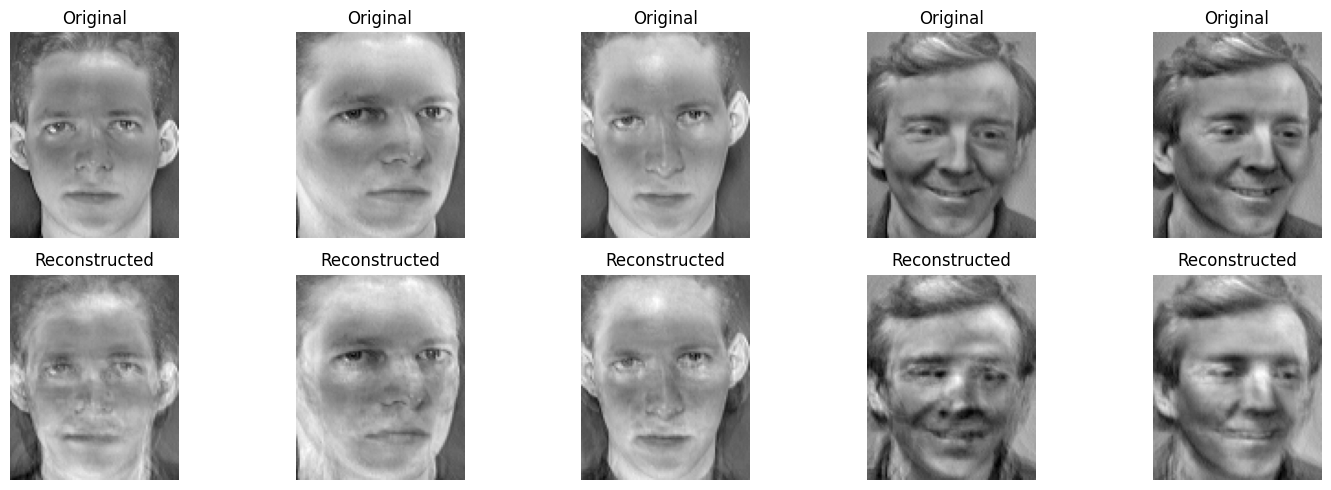

In [631]:
pca = PCA(n_components=int(num_images/2))
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)


# All Principal Components

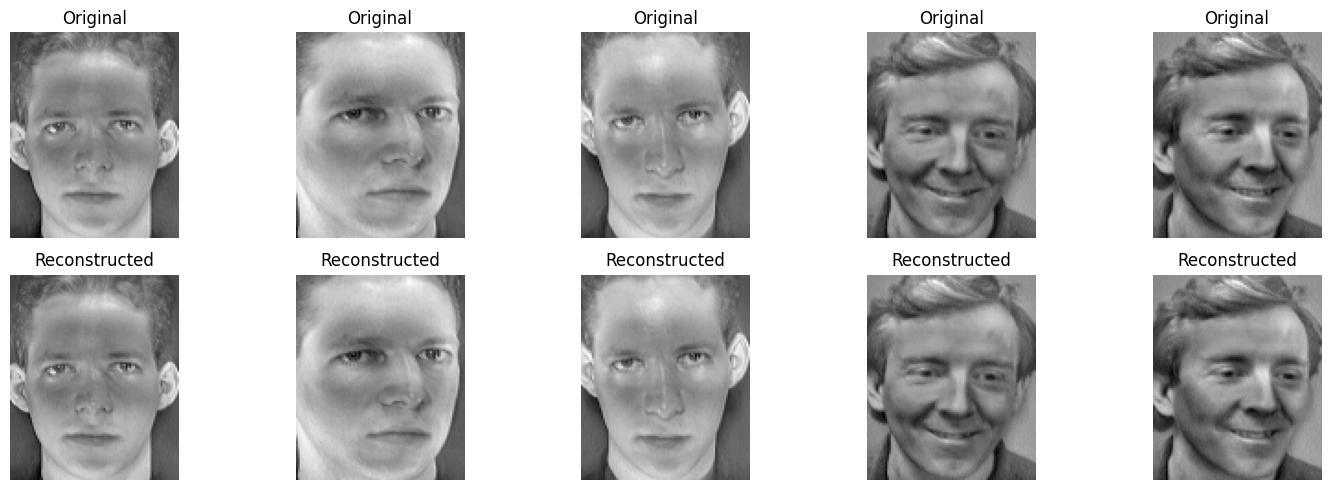

In [632]:
pca = PCA()
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)

## Recursive PCA (Removing image with glasses using PCA on a glassless dataset)

In [685]:
# Recursive PCA

# Reconstruct Image with all principal components
def Reconstruct_Image(input_image, mean_face):
    input_centered = input_image.T - mean_face
    input_projected = pca.transform(input_centered)
    input_reconstructed = pca.inverse_transform(input_projected)
    input_reconstructed += mean_face
    return input_reconstructed.T

# Replace input image with high difference with replacing_image 
def Compensate_Image(input_image, replacing_image, difference_image, lower_threshold, higher_threshold):
    compensated_image = np.zeros((input_image.shape[0], input_image.shape[1]))
    for i in range(difference_image.shape[0]):
        for j in range(difference_image.shape[1]):
            if (difference_image[i][j] >= higher_threshold):
                compensated_image[i][j] = replacing_image[i][j]
            elif (difference_image[i][j] > lower_threshold and difference_image[i][j] < higher_threshold):
                compensated_image[i][j] = replacing_image[i][j] # change to use some linear combination of input image and replacing image
            else:
                compensated_image[i][j] = glass_image.reshape(112, 92)[i][j]
    return compensated_image.reshape(112*92, 1)

# Iteratively apply PCA to input_image to remove glasses
def Recursive_PCA(input_image, difference_stopping_condition):
    mean_face = np.mean(ds, axis=1)
    Z = np.zeros((ds.shape[0], ds.shape[1]))
    for i in range(Z.T.shape[0]):
        Z.T[i] = ds.T[i] - mean_face

    pca = PCA()
    pca.fit(Z.T)
    compensated_images = []

    # First iteration
    reconstructed_image = Reconstruct_Image(input_image, mean_face) # Reconstruct input_image
    difference_image = np.abs(input_image.reshape(112 * 92, 1) - reconstructed_image)
    lower_threshold, higher_threshold = Find_Thresholds(input_image, reconstructed_image) # Obtain lower and higher thresholds from difference image
    compensated_image = Compensate_Image(input_image.reshape(112, 92), mean_face.reshape(112, 92), difference_image.reshape(112, 92), lower_threshold, higher_threshold)
    compensated_images.append(reconstructed_image.reshape(112, 92))
    
    # Subsequent Iterations
    difference = np.abs(compensated_image - input_image)
    while (np.linalg.norm(difference) > difference_stopping_condition):
        difference_image_prev = difference_image
        reconstructed_image = Reconstruct_Image(compensated_image, mean_face)
        difference_image = np.abs(input_image.reshape(112 * 92, 1) - reconstructed_image)
        lower_threshold, higher_threshold = Find_Thresholds(input_image, reconstructed_image)
        compensated_image = Compensate_Image(input_image.reshape(112, 92), reconstructed_image.reshape(112, 92), difference_image.reshape(112, 92), lower_threshold, higher_threshold)
        compensated_images.append(reconstructed_image.reshape(112, 92))
        difference = np.abs(difference_image_prev - difference_image)

    return compensated_images

def Find_Thresholds(input_image, reconstructed_image):
    lower_threshold = 50
    higher_threshold = 100
    return lower_threshold, higher_threshold

glass_image = images[6][3]
glass_image = glass_image.reshape(112 * 92, 1)
reconstructed_images = Recursive_PCA(glass_image, 1e-10)
print("Number of Iterations =", len(reconstructed_images))

Number of Iterations = 28


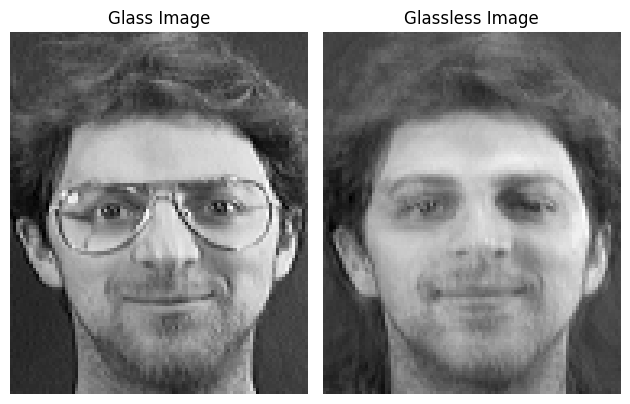

In [686]:
plt.subplot(1, 2, 1)
plt.imshow(glass_image.reshape(112, 92), cmap='gray')
plt.title("Glass Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_images[-1], cmap='gray')
plt.title("Glassless Image")
plt.axis('off')

plt.tight_layout()
plt.show()